<a href="https://colab.research.google.com/github/2303a51851/PDS-Project/blob/main/Reenfcement_leng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Dataset loaded successfully!
Shape: (16032, 25)
Columns: ['Year', 'State Name', 'Dist Name', 'RICE YIELD (Kg per ha)', 'KHARIF SORGHUM YIELD (Kg per ha)', 'PEARL MILLET YIELD (Kg per ha)', 'MAIZE YIELD (Kg per ha)', 'FINGER MILLET YIELD (Kg per ha)', 'PIGEONPEA YIELD (Kg per ha)', 'MINOR PULSES YIELD (Kg per ha)', 'SESAMUM YIELD (Kg per ha)', 'SAFFLOWER YIELD (Kg per ha)', 'CASTOR YIELD (Kg per ha)', 'SUNFLOWER YIELD (Kg per ha)', 'SOYABEAN YIELD (Kg per ha)', 'OILSEEDS YIELD (Kg per ha)', 'SUGARCANE YIELD (Kg per ha)', 'COTTON YIELD (Kg per ha)', 'NITROGEN PER HA OF GCA (Kg per ha)', 'PHOSPHATE PER HA OF GCA (Kg per ha)', 'POTASH PER HA OF GCA (Kg per ha)', 'AVERAGE RAINFALL (Millimeters)', 'AVERAGE TEMPERATURE (Centigrate)', 'AVERAGE PERCIPITATION (Millimeters)', 'SOIL TYPE PERCENT1 (Percent)']
⚠️ No pesticide column found — added placeholder.

✅ Cleaned dataset preview:
   Rainfall  Temperature  Pesticides   Yield
0   178.550    28.713333         0.0  337.59
1   288.000    28.4566

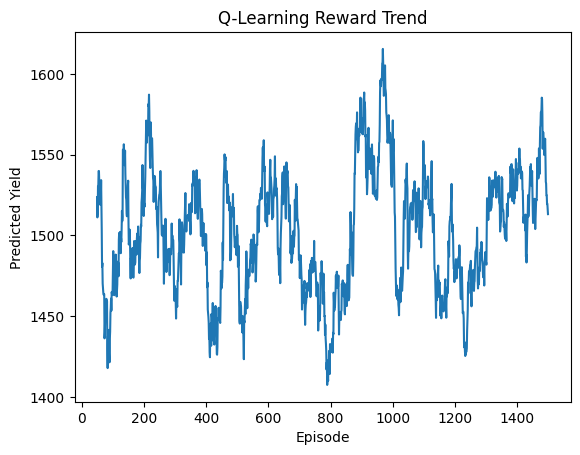

✅ SARSA done. Avg last 100 rewards: 1540.545169052724


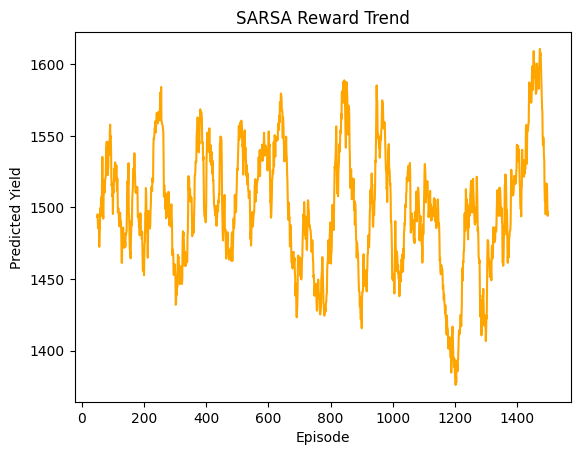

✅ DQN done. Avg last 100 rewards: 1547.1860139866135


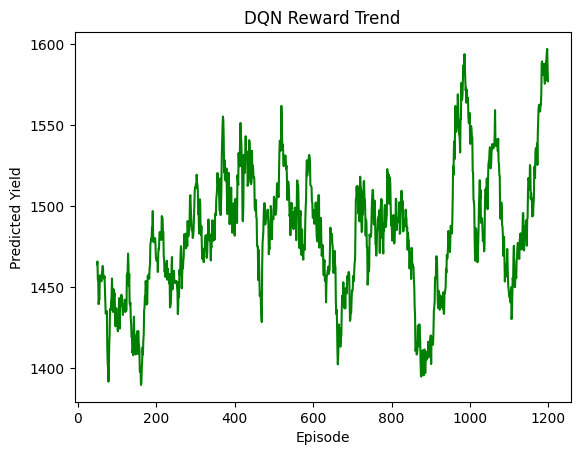


📊 RL Algorithm Comparison:

    Algorithm  Avg Predicted Yield
0  Q-Learning          1501.388632
1       SARSA          1492.611472
2         DQN          1468.633234


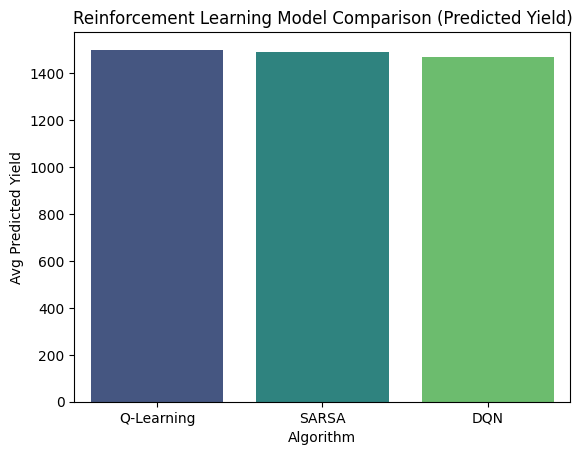

In [8]:
# 🌾 Crop Yield Prediction - Reinforcement Learning Comparison
# -------------------------------------------------------------
# Uses Rainfall, Temperature, and Pesticides to learn a policy that
# maximizes predicted crop yield using Reinforcement Learning.
# Implements: Q-Learning, SARSA, and DQN.
# -------------------------------------------------------------

import os
import random
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML and metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import sklearn
from packaging import version

# RL
from collections import defaultdict, deque
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# -------------------------------------------------------------
# 📂 1. Load Dataset
# -------------------------------------------------------------
df = pd.read_csv("/content/Crop_Yield_Prediction .csv")  # adjust path if needed
print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# Detect columns
def find_col(df, keywords):
    for c in df.columns:
        if any(k in c.lower() for k in keywords):
            return c
    return None

yield_col = find_col(df, ["yield"])
rain_col = find_col(df, ["rain"])
temp_col = find_col(df, ["temp"])
pest_col = find_col(df, ["pesticide", "fertilizer"])

if pest_col is None:
    df["Pesticides"] = 0.0
    pest_col = "Pesticides"
    print("⚠️ No pesticide column found — added placeholder.")

df = df[[rain_col, temp_col, pest_col, yield_col]]
df.columns = ["Rainfall", "Temperature", "Pesticides", "Yield"]
df = df.dropna().drop_duplicates()
print("\n✅ Cleaned dataset preview:")
print(df.head())

# -------------------------------------------------------------
# ⚙️ 2. Train Surrogate Model (Predicting Yield)
# -------------------------------------------------------------
X = df[["Rainfall", "Temperature", "Pesticides"]].values
y = df["Yield"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

surrogate = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
surrogate.fit(X_train, y_train)

# Safe RMSE computation (handles older sklearn versions)
try:
    if version.parse(sklearn.__version__) >= version.parse("0.22"):
        rmse = mean_squared_error(y_test, surrogate.predict(X_test), squared=False)
    else:
        mse = mean_squared_error(y_test, surrogate.predict(X_test))
        rmse = np.sqrt(mse)
except TypeError:
    mse = mean_squared_error(y_test, surrogate.predict(X_test))
    rmse = np.sqrt(mse)

r2 = surrogate.score(X_test, y_test)
print(f"\n✅ Surrogate trained. Test R²: {r2:.4f}, RMSE: {rmse:.4f}")
print(f"(scikit-learn {sklearn.__version__})")

# -------------------------------------------------------------
# 🧩 3. Environment Simulation
# -------------------------------------------------------------
class CropEnv:
    def __init__(self, df, model, scaler, n_rain_bins=5, n_temp_bins=5):
        self.df = df
        self.model = model
        self.scaler = scaler

        self.rain_bins = np.quantile(df["Rainfall"], np.linspace(0, 1, n_rain_bins + 1))
        self.temp_bins = np.quantile(df["Temperature"], np.linspace(0, 1, n_temp_bins + 1))

        minp, maxp = df["Pesticides"].min(), df["Pesticides"].max()
        if maxp == minp:
            maxp = minp + 1
        self.pesticide_actions = np.linspace(minp, maxp, 5)

        self.weather_samples = df[["Rainfall", "Temperature"]].values
        self.reset()

    def reset(self):
        idx = np.random.randint(0, len(self.weather_samples))
        self.weather = self.weather_samples[idx]
        self.current_pest = 0.0
        return self._obs()

    def _obs(self):
        return np.array([self.weather[0], self.weather[1], self.current_pest])

    def step(self, action_idx):
        pest_choice = float(self.pesticide_actions[action_idx])
        self.current_pest = pest_choice
        obs_scaled = self.scaler.transform(np.array([self._obs()]))
        predicted_yield = float(self.model.predict(obs_scaled)[0])
        reward = predicted_yield
        done = True
        return self._obs(), reward, done, {"predicted_yield": predicted_yield}

    def action_space_n(self):
        return len(self.pesticide_actions)

    def sample_action(self):
        return np.random.randint(0, self.action_space_n())

    def discretize_obs(self, obs):
        rain, temp, pest = obs
        rain_bin = np.digitize(rain, self.rain_bins) - 1
        temp_bin = np.digitize(temp, self.temp_bins) - 1
        pest_idx = np.argmin(np.abs(self.pesticide_actions - pest))
        return (int(rain_bin), int(temp_bin), int(pest_idx))

env = CropEnv(df, surrogate, scaler)
print("\n✅ Environment ready with", env.action_space_n(), "actions.")

# -------------------------------------------------------------
# 🧠 4. Q-Learning
# -------------------------------------------------------------
def run_q_learning(env, episodes=1000, alpha=0.5, gamma=0.99, eps=1.0, eps_decay=0.995, min_eps=0.01):
    Q = defaultdict(lambda: np.zeros(env.action_space_n()))
    rewards = []
    for ep in range(episodes):
        obs = env.reset()
        state = env.discretize_obs(obs)
        action = env.sample_action() if np.random.rand() < eps else np.argmax(Q[state])
        _, r, _, _ = env.step(action)
        Q[state][action] += alpha * (r - Q[state][action])
        rewards.append(r)
        eps = max(min_eps, eps * eps_decay)
    return Q, rewards

Q_table, q_rewards = run_q_learning(env, episodes=1500)
print("\n✅ Q-Learning done. Avg last 100 rewards:", np.mean(q_rewards[-100:]))
plt.plot(pd.Series(q_rewards).rolling(50).mean())
plt.title("Q-Learning Reward Trend")
plt.xlabel("Episode"); plt.ylabel("Predicted Yield")
plt.show()

# -------------------------------------------------------------
# 🔁 5. SARSA
# -------------------------------------------------------------
def run_sarsa(env, episodes=1500, alpha=0.5, gamma=0.99, eps=1.0, eps_decay=0.995, min_eps=0.01):
    Q = defaultdict(lambda: np.zeros(env.action_space_n()))
    rewards = []
    for ep in range(episodes):
        obs = env.reset()
        state = env.discretize_obs(obs)
        action = env.sample_action() if np.random.rand() < eps else np.argmax(Q[state])
        _, r, _, _ = env.step(action)
        next_state = env.discretize_obs(obs)
        next_action = env.sample_action() if np.random.rand() < eps else np.argmax(Q[next_state])
        Q[state][action] += alpha * (r + gamma * Q[next_state][next_action] - Q[state][action])
        rewards.append(r)
        eps = max(min_eps, eps * eps_decay)
    return Q, rewards

Q_sarsa, sarsa_rewards = run_sarsa(env)
print("✅ SARSA done. Avg last 100 rewards:", np.mean(sarsa_rewards[-100:]))
plt.plot(pd.Series(sarsa_rewards).rolling(50).mean(), color="orange")
plt.title("SARSA Reward Trend")
plt.xlabel("Episode"); plt.ylabel("Predicted Yield")
plt.show()

# -------------------------------------------------------------
# ⚡ 6. Deep Q-Network (DQN)
# -------------------------------------------------------------
class DQNAgent:
    def __init__(self, state_dim, n_actions, lr=1e-3, gamma=0.99, tau=0.01):
        self.n_actions = n_actions
        self.gamma = gamma
        self.tau = tau
        self.model = self._build_model(state_dim, lr)
        self.target = self._build_model(state_dim, lr)
        self.target.set_weights(self.model.get_weights())
        self.memory = deque(maxlen=5000)

    def _build_model(self, state_dim, lr):
        model = models.Sequential([
            layers.Input(shape=(state_dim,)),
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(self.n_actions, activation="linear")
        ])
        model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
        return model

    def act(self, state, eps=0.1):
        if np.random.rand() < eps:
            return np.random.randint(self.n_actions)
        q_values = self.model.predict(state.reshape(1,-1), verbose=0)[0]
        return np.argmax(q_values)

    def store(self, s, a, r, ns, done):
        self.memory.append((s,a,r,ns,done))

    def train(self, batch_size=64):
        if len(self.memory) < 10:
            return
        batch_size = min(batch_size, len(self.memory))
        batch = random.sample(self.memory, batch_size)
        s,a,r,ns,d = map(np.array, zip(*batch))
        q_target = self.model.predict(s, verbose=0)
        q_next = self.target.predict(ns, verbose=0)
        q_next_max = np.max(q_next, axis=1)
        for i in range(batch_size):
            q_target[i, a[i]] = r[i] + (0 if d[i] else self.gamma * q_next_max[i])
        self.model.train_on_batch(s, q_target)
        self._soft_update()

    def _soft_update(self):
        w, wt = self.model.get_weights(), self.target.get_weights()
        self.target.set_weights([self.tau*wm + (1-self.tau)*wtm for wm,wtm in zip(w,wt)])

agent = DQNAgent(3, env.action_space_n())

def run_dqn(env, agent, episodes=1000, eps=1.0, eps_decay=0.995, eps_min=0.05):
    rewards = []
    for ep in range(episodes):
        obs = env.reset()
        s = env.scaler.transform(np.array([obs]))[0]
        a = agent.act(s, eps)
        ns, r, done, _ = env.step(a)
        ns_scaled = env.scaler.transform(np.array([ns]))[0]
        agent.store(s,a,r,ns_scaled,done)
        agent.train(batch_size=64)
        rewards.append(r)
        eps = max(eps_min, eps*eps_decay)
    return rewards

dqn_rewards = run_dqn(env, agent, episodes=1200)
print("✅ DQN done. Avg last 100 rewards:", np.mean(dqn_rewards[-100:]))
plt.plot(pd.Series(dqn_rewards).rolling(50).mean(), color="green")
plt.title("DQN Reward Trend")
plt.xlabel("Episode"); plt.ylabel("Predicted Yield")
plt.show()

# -------------------------------------------------------------
# 📊 7. Evaluation
# -------------------------------------------------------------
def evaluate_tabular(env, Q):
    rews = []
    for _ in range(200):
        obs = env.reset()
        state = env.discretize_obs(obs)
        a = np.argmax(Q[state])
        _, r, _, _ = env.step(a)
        rews.append(r)
    return np.mean(rews)

def evaluate_dqn(env, agent):
    rews = []
    for _ in range(200):
        obs = env.reset()
        s = env.scaler.transform(np.array([obs]))[0]
        a = agent.act(s, eps=0.0)
        _, r, _, _ = env.step(a)
        rews.append(r)
    return np.mean(rews)

q_mean = evaluate_tabular(env, Q_table)
sarsa_mean = evaluate_tabular(env, Q_sarsa)
dqn_mean = evaluate_dqn(env, agent)

summary = pd.DataFrame({
    "Algorithm": ["Q-Learning", "SARSA", "DQN"],
    "Avg Predicted Yield": [q_mean, sarsa_mean, dqn_mean]
})
print("\n📊 RL Algorithm Comparison:\n")
print(summary)

sns.barplot(data=summary, x="Algorithm", y="Avg Predicted Yield", palette="viridis")
plt.title("Reinforcement Learning Model Comparison (Predicted Yield)")
plt.show()
